This project utilizes a dataset containing 20,000 chess games sourced from Lichess, featuring matches played between 2013 and 2017 by members of the top ~100 teams on lichess.org.
The goal is to develop a predictive model that can forecast the outcome of a chess game before it begins, using available game parameters
Dataset source: Kaggle - https://www.kaggle.com/datasets/datasnaek/chess

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 200)

Populating the interactive namespace from numpy and matplotlib


Importing the dataset:

In [ ]:
chess_games = pd.read_csv('/content/games.csv', delimiter=',')

In [ ]:
chess_games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


# Features

### Duration of the match

In [ ]:
games_delay_in_sec = (chess_games['last_move_at'] - chess_games['created_at']) / 1000
chess_games['duration_in_seconds'] = games_delay_in_sec.copy()

### One-Hot-Encoding of victory status

In [ ]:
!pip install category_encoders
from category_encoders import OneHotEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
ohe_victory_status = OneHotEncoder(cols=['victory_status'], use_cat_names=True, drop_invariant=True)
chess_games = ohe_victory_status.fit_transform(chess_games)

### Time control: Minutes and Seconds

In [ ]:
minutes = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[0], na_action=None).astype(int)
incr_seconds = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[1], na_action=None).astype(int)

chess_games['minutes'] = minutes.copy()
chess_games['incr_seconds'] = incr_seconds.copy()

In [ ]:
chess_games = chess_games.drop(columns=['increment_code'], axis=1)

### Date of Creation and Last Move At (as dates)

In [ ]:
chess_games['created_at'] = pd.to_datetime(chess_games['created_at'], unit='ms')
chess_games['last_move_at'] = pd.to_datetime(chess_games['last_move_at'], unit='ms')

### Rating difference

One other variable that seems to be predictive is the rating difference between the players.

In [ ]:
chess_games['rating_difference'] = chess_games['white_rating'] - chess_games['black_rating']

In [ ]:
chess_games['rating_difference'].mean()

np.float64(7.799880346993718)

### Castle

In [ ]:
def get_white_moves(moves):
    return moves[::2]

def get_black_moves(moves):
    return moves[1::2]

def castled(moves):
    return ('O-O' in moves) | ('O-O-O' in moves)

all_moves = chess_games['moves'].str.split()
white_moves = all_moves.apply(get_white_moves)
black_moves = all_moves.apply(get_black_moves)
chess_games['white_castled'] = white_moves.apply(castled).astype(int)
chess_games['black_castled'] = black_moves.apply(castled).astype(int)

### Number of takes

In [ ]:
def count_takes(moves):
    moves = pd.Series(moves)
    return moves.map(lambda mv: 1 if 'x' in mv else 0).sum()

chess_games['white_takes_count'] = white_moves.apply(count_takes)
chess_games['black_takes_count'] = black_moves.apply(count_takes)

In [ ]:
chess_games.head()

,id,rated,created_at,last_move_at,turns,victory_status_outoftime,victory_status_resign,victory_status_mate,victory_status_draw,winner,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,duration_in_seconds,minutes,incr_seconds,rating_difference,white_castled,black_castled,white_takes_count,black_takes_count
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,1,0,0,0,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,0.0,15,2,309,0,0,2,1
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,0,1,0,0,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,0.0,5,10,61,0,0,2,3
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,0,0,1,0,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,0.0,5,10,-4,0,0,14,3
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,0,0,1,0,white,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,0.0,20,0,-15,1,1,10,4
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,0,0,1,0,white,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,0.0,30,3,54,1,1,14,10


# Clean Data

We calculate a threshold in hours for a match:

In [ ]:
max_minutes = chess_games['minutes'].max()
max_incr_seconds = chess_games['incr_seconds'].max()
mean_moves = chess_games['turns'].mean()

duration_threshold_in_hours = (max_minutes + max_incr_seconds / 60 * mean_moves) / 60
duration_threshold_in_hours

np.float64(6.0232999302024135)

So, we remove the matches which have until 3 turns (not possible to checkmate in 3 turns), and the ones with duration until 6 hours.

In [ ]:
chess_games = chess_games[chess_games['turns'] > 3]
chess_games = chess_games[chess_games['duration_in_seconds'] < duration_threshold_in_hours * 3600]

In [ ]:
chess_games.shape

(19766, 26)

We see we have also matches which have 0 seconds.

In [ ]:
duration0 = chess_games[chess_games['duration_in_seconds'] == 0]
duration0['winner'].value_counts()

,count
winner,
white,4207
black,3910
draw,355


Let's see the distribution of the matches' duration:

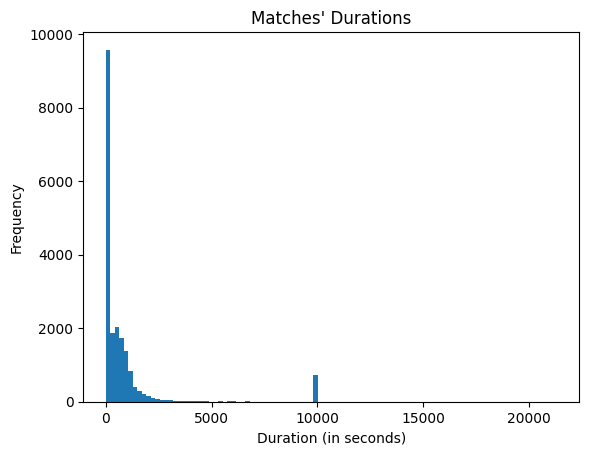

In [ ]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

Let's filter the matches with duration_in_seconds > 0.

In [ ]:
chess_games = chess_games[chess_games['duration_in_seconds'] > 0]

In [ ]:
chess_games.shape

(11294, 26)

Reploting the durations, without the zeroes:

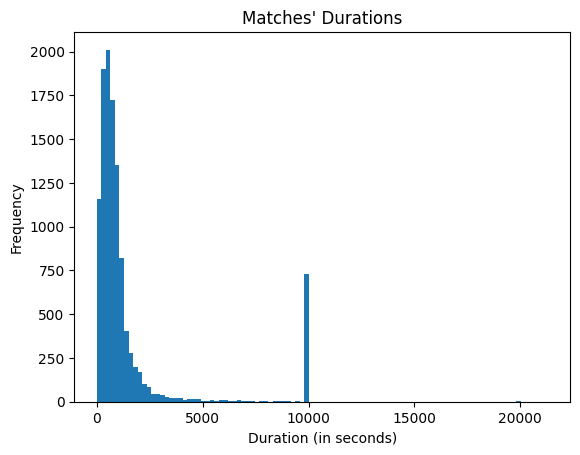

In [ ]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

The peak at ~10000 s = ~2.7 hours is a plausible match duration.

# Baseline

Let's take as **baseline case** the result as a function of the rating difference points (diff):

If
* \- (mean difference)  < diff < (mean difference)  => draw;
* else, diff is negative => black wins
* else => white wins

In [ ]:
baseline = pd.DataFrame(index=chess_games.index)
baseline['rating_difference'] = chess_games['rating_difference']
baseline.shape

(11294, 1)

In [ ]:
baseline['rating_difference'].mean()

np.float64(7.085532140959802)

In [ ]:
def get_base_winner(rating_diff):
    average = baseline['rating_difference'].mean()
    if rating_diff < average and rating_diff > -average:
        return 'draw'
    elif rating_diff < 0:
        return 'black'
    else:
        return 'white'

baseline['winner'] = baseline['rating_difference'].apply(get_base_winner)
baseline['winner'].value_counts()

,count
winner,
white,5505
black,5201
draw,588


Let's use the **weighted avg precison** and **weighted avg recall** as our modeling metrics, so we balance the different quantities of examples for each result.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [ ]:
print(classification_report(chess_games['winner'], baseline['winner'], digits=4))

              precision    recall  f1-score   support

       black     0.5978    0.6127    0.6052      5074
        draw     0.0544    0.0551    0.0547       581
       white     0.6449    0.6295    0.6371      5639

    accuracy                         0.5924     11294
   macro avg     0.4324    0.4325    0.4323     11294
weighted avg     0.5933    0.5924    0.5928     11294



p 0.5933, recall 0.5924 - Baseline

Looking how to capture the **weighted avg precison**, we use its definition: _weighted_avg_precision = weighted_avg(precision, support)_

In [ ]:
results = precision_recall_fscore_support(chess_games['winner'], baseline['winner'])
np.average(results[0], weights=results[3])

np.float64(0.5933340404857875)

# Constructing the model

We import the Random Forest Classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Let's use the following variables to make the model:

(we include castled, takes quantity, rating difference)

In [ ]:
variables = ['victory_status_outoftime', 'victory_status_resign', 'victory_status_mate', 'victory_status_draw',
             'white_rating', 'black_rating', 'minutes', 'incr_seconds', 'rating_difference',
             'white_castled', 'black_castled', 'white_takes_count', 'black_takes_count']

As the dataset is small, let's divide 50% train / 50% validation.

In [ ]:
print(chess_games.columns)
#from category_encoders import OneHotEncoder

#ohe_victory_status = OneHotEncoder(cols=['victory_status'], use_cat_names=True, drop_invariant=True)
#chess_games = ohe_victory_status.fit_transform(chess_games)

X = chess_games[variables]
y = chess_games['winner']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5)

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns',
       'victory_status_outoftime', 'victory_status_resign',
       'victory_status_mate', 'victory_status_draw', 'winner', 'white_id',
       'white_rating', 'black_id', 'black_rating', 'moves', 'opening_eco',
       'opening_name', 'opening_ply', 'duration_in_seconds', 'minutes',
       'incr_seconds', 'rating_difference', 'white_castled', 'black_castled',
       'white_takes_count', 'black_takes_count'],
      dtype='object')


In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5647, 13), (5647, 13), (5647,), (5647,))

We train the model.

In [ ]:
model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

predicted = model.predict(X_valid)

results = precision_recall_fscore_support(y_valid, predicted)
support = results[3]
prec = np.average(results[0], weights=support)
recall = np.average(results[1], weights=support)
print("Precision: {}".format(prec))
print("Recall: {}".format(recall))
print()

Precision: 0.8113848551545693
Recall: 0.8110501151053657



We have a great increase of both the metrics using the variables **white_takes_count, black_takes_count.**

# Cross-validation

In order to have a better estimate of the metrics, let's use KFold to do cross-validation of the data.

In [ ]:
from sklearn.model_selection import RepeatedKFold

In [ ]:
avg_weighted_precisions = []
avg_weighted_recalls = []
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

X = chess_games[variables]
y = chess_games['winner']
i = 0

for lines_train, lines_valid in kf.split(chess_games):
    X_train, y_train = X.iloc[lines_train], y.iloc[lines_train]
    X_valid, y_valid = X.iloc[lines_valid], y.iloc[lines_valid]
    i = i + 1

    model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
    model.fit(X_train, y_train)

    predicted = model.predict(X_valid)

    results = precision_recall_fscore_support(y_valid, predicted)
    support = results[3]
    prec = np.average(results[0], weights=support)
    recall = np.average(results[1], weights=support)
    print("Iteration  #{}".format(i))
    print("=====================")
    print("Precision: {}".format(prec))
    print("Recall: {}".format(recall))
    print()

    avg_weighted_precisions.append(prec)
    avg_weighted_recalls.append(recall)

print("Average Precision: {}".format(np.mean(avg_weighted_precisions)))
print("Average Recall: {}".format(np.mean(avg_weighted_recalls)))

Iteration  #1
Precision: 0.8022068393254235
Recall: 0.8018416858508943

Iteration  #2
Precision: 0.8165330384935984
Recall: 0.8161855852665132

Iteration  #3
Precision: 0.8102628042847981
Recall: 0.8099876040375421

Iteration  #4
Precision: 0.8040823274535771
Recall: 0.8034354524526297

Iteration  #5
Precision: 0.8250654736875628
Recall: 0.8246856738091022

Iteration  #6
Precision: 0.8003204821092943
Recall: 0.8002479192491588

Iteration  #7
Precision: 0.8149214336749095
Recall: 0.8144147334868072

Iteration  #8
Precision: 0.8084545119681279
Recall: 0.8075084115459537

Iteration  #9
Precision: 0.80302163023574
Recall: 0.8027271117407473

Iteration  #10
Precision: 0.8097903587818706
Recall: 0.8094563485036302

Iteration  #11
Precision: 0.810279226334315
Recall: 0.8101646892155127

Iteration  #12
Precision: 0.8075850298669162
Recall: 0.8071542411900124

Iteration  #13
Precision: 0.803472458272922
Recall: 0.8030812820966885

Iteration  #14
Precision: 0.8054476658952456
Recall: 0.805206304

And we see that both the average of precision and the average of recall are near to 80%.

Let's plot the precision and recall distribution to detect possible outliers:

(array([3., 1., 4., 0., 1., 1., 1., 2., 3., 0., 0., 1., 0., 2., 0., 0., 0.,
        0., 0., 1.]),
 array([0.79971666, 0.80096511, 0.80221356, 0.80346202, 0.80471047,
        0.80595892, 0.80720737, 0.80845582, 0.80970427, 0.81095272,
        0.81220117, 0.81344962, 0.81469807, 0.81594652, 0.81719497,
        0.81844342, 0.81969187, 0.82094032, 0.82218877, 0.82343722,
        0.82468567]),
 <BarContainer object of 20 artists>)

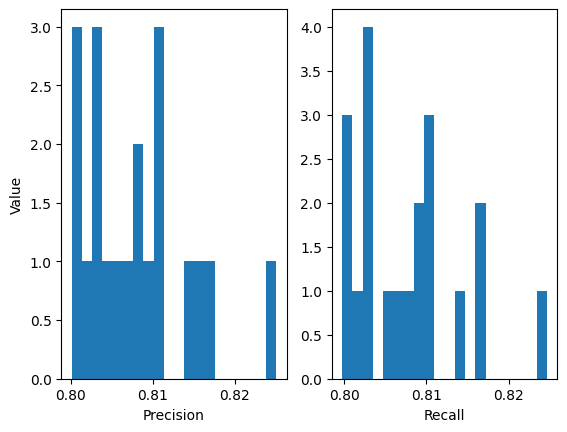

In [ ]:
pylab.subplot(121)
pylab.xlabel('Precision')
pylab.ylabel('Value')
pylab.hist(avg_weighted_precisions, bins=20)

pylab.subplot(122)
pylab.xlabel('Recall')
pylab.hist(avg_weighted_recalls, bins=20)

The values for both the metrics lie in the interval [0.80, 0.82], which is not a big range of values. We haven't detected outliers.

Here are some other configurations tested in order to achieve this first model with metrics around 80%:

* p 0.5933, recall 0.5924 - Baseline

* p 0.6477, recall 0.6473 - Random Forest (n=100)

* p 0.6512, recall 0.6508 - Random Forest (n=200) with 'castled' variables

* p 0.8081, recall 0.8077 - Random Forest (n=200) with 'castled' and 'takes_count' variables

As we can see, we have a great improvement of the performance when we add 'takes_count' variables.